In [1]:
import IPython as ipd
import librosa
from utils import *

import torch
import torch.nn
import torch.optim
from torch.utils.data import IterableDataset

import os
import timeit
from time import time

import torchaudio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DEVICE = "cpu"
if torch.cuda.is_available():
    DEVICE = "cuda"

print(f"USING DEVICE {DEVICE}")

USING DEVICE cuda


In [3]:
# Define source paths. Place data under working directory and name folder "voicedata"
DATA_DIR = "./commands"
TARGET_RATE = 8000
EPOCHS = 10
os.makedirs(DATA_DIR, exist_ok=True)
train_set = SpeechCommandsSubset(root=DATA_DIR, download=True, rate=TARGET_RATE)
test_set = SpeechCommandsSubset(root=DATA_DIR, download=True, subset="testing", rate=TARGET_RATE)
validate_set = SpeechCommandsSubset(root=DATA_DIR, download=True, subset="validation", rate=TARGET_RATE)

# labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels = train_set.labels

print(f'  Training Set: {len(train_set)}')
print(f'   Testing Set: {len(test_set)}')
print(f'Validation Set: {len(validate_set)}')

print(f'   Data Labels: {len(labels)}')

  Training Set: 84843
   Testing Set: 11005
Validation Set: 9981
   Data Labels: 35


# Preview sample 52000

In [4]:
waveform, rate, label, speaker, id = train_set[52000]
print(f"Label: {label} ({label_to_index(label, labels)})")
print(rate)
print(waveform.size())
ipd.display.Audio(data=waveform, rate=rate)

Label: right (22)
8000
torch.Size([1, 8000])


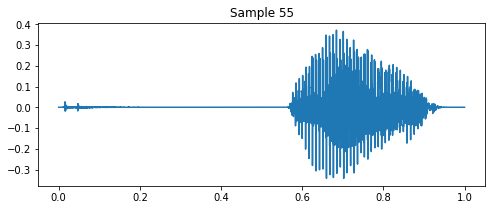

In [5]:
Y = waveform.view(-1).numpy()
times = np.linspace(0, len(Y) / rate, len(Y))
plot(times, Y, title="Sample 55")

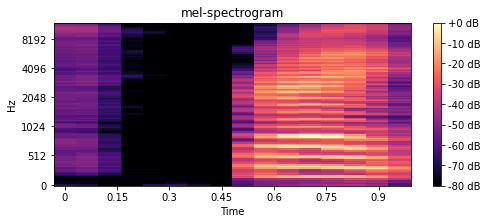

In [6]:
spectrogram = librosa.feature.melspectrogram(y=waveform.view(-1).numpy(), sr=rate)
plot_spectro(spectrogram, rate)

# Experiment with M5

In [50]:
import torch.nn as nn
import torch.nn.functional as F

class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

In [164]:
BATCH_SIZE = 24
LEARNING_RATE = 0.005
NON_LINEARITY = "tanh"

def initialize_model(input_size, hidden_size, non_linearity=NON_LINEARITY, fn=None, learning_rate=LEARNING_RATE, a=-0.8, b=0.01):
    model = M5(n_input=1, n_output=len(labels))
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if not fn:
        loss_fn = torch.nn.CrossEntropyLoss()
    else:
        loss_fn = fn
    
    return model, optimizer, loss_fn

def train_model(model, optimizer, loss_fn, train_data, labels, epochs=1, cap=None):
    # Initialize model
    model.train()
    
    loss_summary = 0
    data_size = 0
    losses = []
    micro_time = 0

    for e in range(epochs):
        print(f"=> [{e}] ", end="")
        
        num_workers = 0 if DEVICE=="cpu" else 4
        pin_memory = False if DEVICE=="cpu" else True
        
        data_loader = torch.utils.data.DataLoader(
            train_data,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=pin_memory
        )

        diverged = False
        count = 0.0
        for waveform, rate, label, speaker, id in data_loader:
            if cap and count > cap:
                break
            count += 1

            optimizer.zero_grad()
            target = torch.tensor([label_to_index(x, labels) for x in label])
                
            waveform = waveform.to(DEVICE)
            target = target.to(DEVICE)

            before = time()
            output = model(waveform)
            batch_len = waveform.shape[0]

            loss = loss_fn(output.view(batch_len, -1), target)
            loss_summary += loss.item() * batch_len
            data_size += batch_len

            # print(loss_summary)
            # print(output.reshape(BATCH_SIZE, -1), target)

            if not diverged and loss.item() != loss.item():
                print("DIVERGED at ", count)
                diverged = True
                print("output:", torch.max(output).item())
                print("target:", target)
                print("hidden:", hidden)
                print("hidden:", hidden_next)
                print("  loss:", loss.item)
                break

            loss.backward()
            optimizer.step()

            micro_time = time() - before

        # print("loss:", loss_summary)
        losses.append(loss_summary / data_size)
    print("train time: ", micro_time * 1000)
    return losses

In [165]:
losses = []
times = []
def timed_test(rate=TARGET_RATE, fn=None, lr=0.005, cap=None, ep=5):
    m, o, l = initialize_model(rate, len(labels), fn=fn, a=-1.5, b=0.08, learning_rate=lr)
    before = time()
    losses.append(train_model(m, o, l, train_set, labels, epochs=ep, cap=cap))
    result = time() - before
    times.append(result)
    
timed_test(fn=torch.nn.CrossEntropyLoss(), lr=0.005, cap=100)
print(losses)
print(times)

=> [0] => [1] => [2] => [3] => [4] train time:  4.285573959350586
[[3.3590749726437106, 3.0528520381096564, 2.855831305579384, 2.709578918643517, 2.590476611817237]]
[3.2423431873321533]


In [166]:
DEF_CAP=100
DEF_EPOCHS=5

=> [0] => [1] => [2] => [3] => [4] train time:  2.516031265258789
=> [0] => [1] => [2] => [3] => [4] train time:  3.780364990234375
=> [0] => [1] => [2] => [3] => [4] train time:  3.3638477325439453
=> [0] => [1] => [2] => [3] => [4] train time:  2.61688232421875
=> [0] => [1] => [2] => [3] => [4] train time:  4.362344741821289
=> [0] => [1] => [2] => [3] => [4] train time:  2.7313232421875
=> [0] => [1] => [2] => [3] => [4] train time:  2.67791748046875
=> [0] => [1] => [2] => [3] => [4] train time:  2.4907588958740234
[[3.500129768163851, 3.359941072983317, 3.229372943588609, 3.107338774912428, 2.9969446059500817], [3.410120718549974, 3.2162143039231252, 3.0261338481021793, 2.865042893308224, 2.742524477278832], [3.5274913594274238, 3.2555715010897948, 3.0316765284774325, 2.8641411679806095, 2.7388662397271335], [3.391540196862551, 3.1224833290175638, 2.9093473079574386, 2.7493859800961937, 2.6298863276396647], [3.4676268029921125, 3.1892261044813854, 2.9961612468505456, 2.8298608457

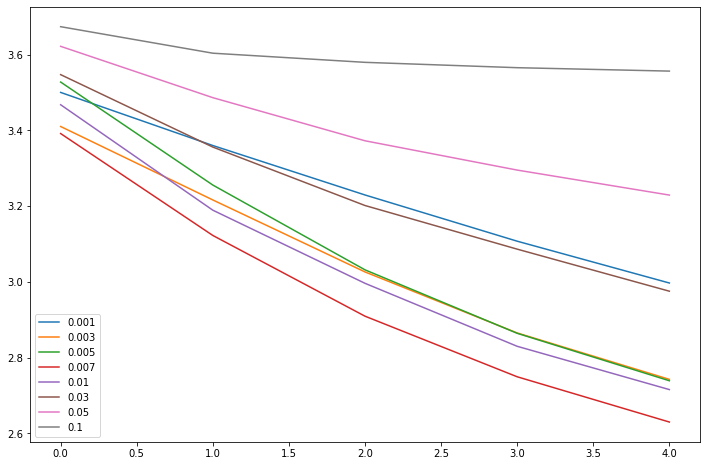

In [167]:
losses = []
times = []
rates = [0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.1]
for r in rates:
    timed_test(fn=torch.nn.CrossEntropyLoss(), lr=r, cap=DEF_CAP, ep=DEF_EPOCHS)

fig, ax = plt.subplots(1, 1, figsize=(12,8))
for l in losses:
    plot(list(range(DEF_EPOCHS)), l, ax=ax)
ax.legend(rates)
    
print(losses)
print(times)

In [120]:
losses = []
times = []
rates = [0.001, 0.003, 0.005, 0.007, 0.01]
for r in rates:
    timed_test(fn=torch.nn.CrossEntropyLoss(), lr=r, cap=None, ep=20)

fig, ax = plt.subplots(1, 1, figsize=(8,3))
for l in losses:
    plot(list(range(DEF_EPOCHS)), l, ax=ax)
ax.legend(rates)
    
print(losses)
print(times)

=> Epoch 0 => Epoch 1 => Epoch 2 => Epoch 3 

KeyboardInterrupt: 

=> [0] => [1] => [2] => [3] => [4] train time:  2.520322799682617
=> [0] => [1] => [2] => [3] => [4] train time:  2.736330032348633
[[3.471386961417623, 3.2050111506244923, 2.989321060306562, 2.819540597719721, 2.6940633799770093], [3.4203670473382024, 3.1551206430586256, 2.958049167500864, 2.813888988577493, 2.699110743078855]]
[3.343027114868164, 3.225858688354492]


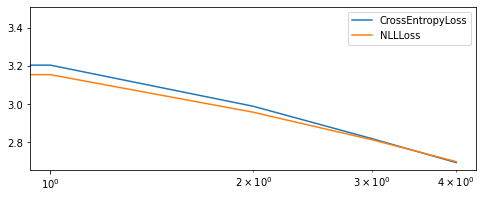

In [168]:
losses = []
times = []
fns = [
    torch.nn.CrossEntropyLoss(),
    torch.nn.NLLLoss()
]
names =["CrossEntropyLoss", "NLLLoss"]
for f in fns:
    timed_test(fn=f, lr=0.005, cap=DEF_CAP, ep=DEF_EPOCHS)

fig, ax = plt.subplots(1, 1, figsize=(8,3))
for l in losses:
    plot(list(range(DEF_EPOCHS)), l, ax=ax)
ax.legend(names)
ax.set_xscale("log")
    
print(losses)
print(times)

In [197]:
def eval_model(model, loss_fn, test_data, cap=3, batch_size = 10):
    with torch.no_grad():
        model.eval()
        loss_summary = 0
        data_size = 0
        attempts = 0
        hits = 0

        num_workers = 0 if DEVICE=="cpu" else 4
        pin_memory = False if DEVICE=="cpu" else True
        
        data_loader = torch.utils.data.DataLoader(
            test_data,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=pin_memory
        )

        count = 0
        for waveform, rate, label, speaker, id in data_loader:
            if cap and count > cap:
                break
            count += 1

            # send data to target device
            waveform = waveform.to(DEVICE)
            target = torch.tensor([label_to_index(x, labels) for x in label])
            target = target.to(DEVICE)
            batch_len = waveform.shape[0]

            # Predict, calculate loss, calculate gradients
            output = model(waveform)

            loss = loss_fn(output.view(batch_len, -1), target)
            loss_summary += loss.item()
            data_size += batch_len
            
            prediction = torch.argmax(output.view(batch_len, -1), dim=1)
            hits += prediction[prediction == target].shape[0]
            attempts += prediction.shape[0]
            # print(prediction == target)
            # print(prediction[prediction == target])

        loss_summary = loss_summary / data_size
        return model, loss_summary, attempts, hits

In [198]:
losses = []
times = []
accuracies = []
correct = []
def timed_test(rate=TARGET_RATE, fn=None, lr=0.005, cap=None, ep=5):
    m, o, l = initialize_model(rate, len(labels), fn=fn, a=-1.5, b=0.08, learning_rate=lr)
    before = time()
    losses.append(train_model(m, o, l, train_set, labels, epochs=ep, cap=cap))
    result = time() - before
    times.append(result)
    
    m, loss, attempts, hits = eval_model(m, l, test_set, cap=cap)
    accuracies.append(hits/attempts)
    correct.append(hits)
    
    
timed_test(fn=torch.nn.CrossEntropyLoss(), lr=0.005, cap=5)
print(losses)
print(times)
print(accuracies)
print(correct)

=> [0] => [1] => [2] => [3] => [4] train time:  2.190113067626953
[[3.7629928986231485, 3.7461954951286316, 3.680842545297411, 3.650719831387202, 3.6276708285013837]]
[1.1827526092529297]
[0.11666666666666667]
[7]


In [203]:
DEF_CAP=None
DEF_EPOCHS=10

In [204]:
losses = []
times = []
accuracies = []
correct = []
rates = [0.001, 0.003, 0.005, 0.007, 0.01]
for r in rates:
    print(f"== training learning rate: {r}")
    timed_test(fn=torch.nn.CrossEntropyLoss(), lr=r, cap=DEF_CAP, ep=DEF_EPOCHS)
    print(f"     accuracy: {accuracies[-1] * 100:.2f}%")
    print(f"   train time: {times[-1]:.3f}")

== training learning rate: 0.001
=> [0] => [1] => [2] => [3] => [4] => [5] => [6] => [7] => [8] => [9] train time:  1.9924640655517578
     accuracy: 82.54%
   train time: 153.806
== training learning rate: 0.003
=> [0] => [1] => [2] => [3] => [4] => [5] => [6] => [7] => [8] => [9] train time:  2.065420150756836
     accuracy: 82.44%
   train time: 152.134
== training learning rate: 0.005
=> [0] => [1] => [2] => [3] => [4] => [5] => [6] => [7] => [8] => [9] train time:  2.0589828491210938
     accuracy: 78.40%
   train time: 152.628
== training learning rate: 0.007
=> [0] => [1] => [2] => [3] => [4] => [5] => [6] => [7] => [8] => [9] train time:  2.0568370819091797
     accuracy: 79.77%
   train time: 151.734
== training learning rate: 0.01
=> [0] => [1] => [2] => [3] => [4] => [5] => [6] => [7] => [8] => [9] train time:  2.1216869354248047
     accuracy: 80.55%
   train time: 151.533


[[1.6718983323194447, 1.3203790613083357, 1.1549066121273628, 1.051078696312731, 0.9792064915388419, 0.9247041987942926, 0.8813330955122982, 0.8461303092299045, 0.8168321435608565, 0.7918501646490002], [1.597233370607735, 1.2764201584687973, 1.1212384795555053, 1.0240919425690236, 0.9567468500821293, 0.9061523767078926, 0.8654893941544192, 0.8323477207008633, 0.8043547992456827, 0.7805588245569937], [1.5913099169094649, 1.2924124095295837, 1.1487311390301291, 1.057851624611703, 0.9925002388323404, 0.942723711622181, 0.9029166331178811, 0.8708628620146874, 0.8431500493716718, 0.8191660164773126], [1.6587610053677213, 1.34150632253475, 1.1880772637148824, 1.0945242548225151, 1.0285556336313497, 0.9785886342764651, 0.9395137065154864, 0.9082351397425394, 0.8814018585125616, 0.8582784185441243], [1.618721292125197, 1.3162973836648666, 1.1720474344111118, 1.082777385527825, 1.0200264315937995, 0.9710895169854815, 0.9330246244949613, 0.9014892817772039, 0.8748594854951429, 0.8517683564407907

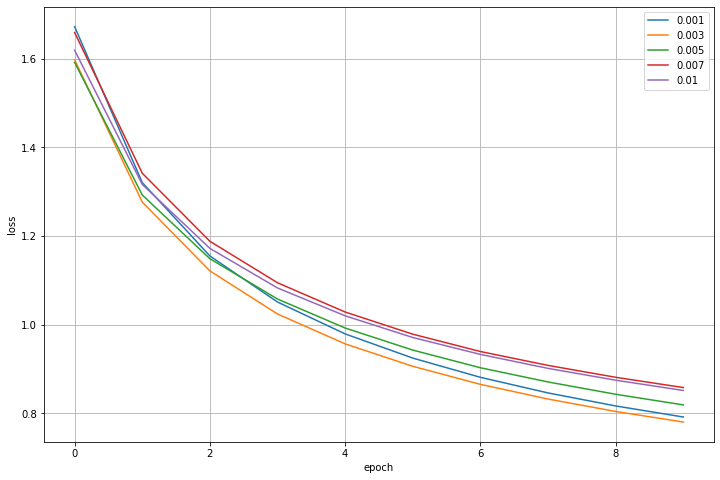

In [208]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
for l in losses:
    plot(list(range(DEF_EPOCHS)), l, ax=ax)
ax.legend(rates)
ax.set_xlabel("epoch")
ax.grid(True)
ax.set_ylabel("loss")
print(losses)

[0.8253521126760563, 0.8243525670149932, 0.7840072694229896, 0.7977283053157656, 0.805542935029532]


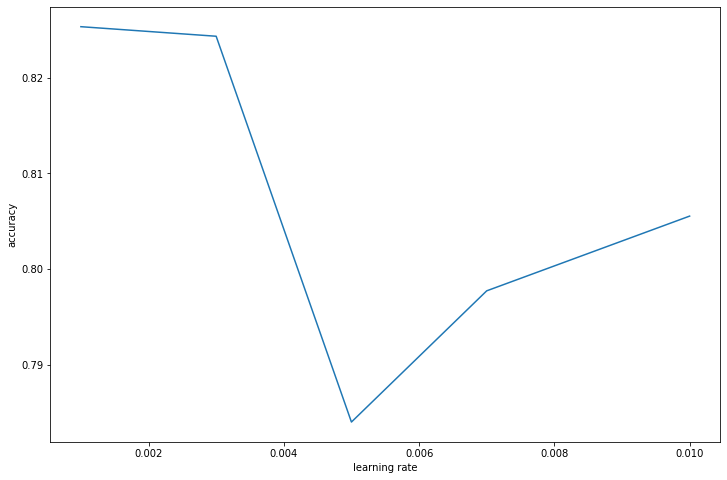

In [206]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
plot(rates, accuracies, ax=ax)
ax.set_xlabel("learning rate")
ax.set_ylabel("accuracy")
print(accuracies)

[9083, 9072, 8628, 8779, 8865]


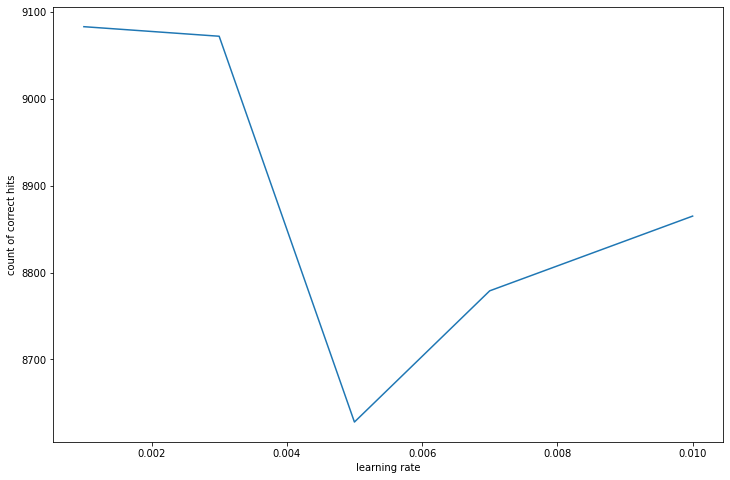

In [207]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
plot(rates, correct, ax=ax)
ax.set_xlabel("learning rate")
ax.set_ylabel("count of correct hits")
print(correct)

# Define and run the model

In [7]:
FUNCTIONS = {
    "tanh": torch.nn.Tanh(),
    "sigmoid": torch.nn.Sigmoid(),
    "relu": torch.nn.ReLU()
}

class ImprovedRNNCell(RNNCell):
    '''
    Simple RNN with weighted residual connection.
    '''

    def __init__(self, input_size, hidden_size,
                 update_nonlinearity="tanh",
                 wSparsity=1.0, uSparsity=1.0, alphaInit=-3.0, betaInit=3.0,
                 name="ImprovedRNN"):
        super(ImprovedRNNCell, self).__init__(input_size, hidden_size,
                                           None, update_nonlinearity,
                                           1, 1, 1, 0, 0, wSparsity,
                                           uSparsity)
        # TODO: Initialize all the required variables
        
        # Reduce W and U starting values to a small fraction.
        self.W = torch.randn((hidden_size, hidden_size), requires_grad=True).to(DEVICE)
        self.U = torch.randn((hidden_size, input_size), requires_grad=True) * .1
        self.U = self.U.to(DEVICE)
        self.V = torch.randn((hidden_size, hidden_size), requires_grad=True).to(DEVICE)
        self.b = torch.zeros(hidden_size, requires_grad=True).to(DEVICE)
        self.c = torch.zeros(hidden_size, requires_grad=True).to(DEVICE)
        
        self.alpha = torch.tensor(alphaInit, requires_grad=True).to(DEVICE)
        self.beta = torch.tensor(betaInit, requires_grad=True).to(DEVICE)
        
        self.W = torch.nn.Parameter(self.W)
        self.U = torch.nn.Parameter(self.U)
        self.V = torch.nn.Parameter(self.V)
        self.b = torch.nn.Parameter(self.b)
        self.c = torch.nn.Parameter(self.c)
        self.alpha = torch.nn.Parameter(self.alpha)
        self.beta = torch.nn.Parameter(self.beta)
       
        self.update_nl = FUNCTIONS[update_nonlinearity]
        
        self._name = name

    @property
    def name(self):
        return self._name

    @property
    def cellType(self):
        return "ImprovedRNN"

    def forward(self, input, state):
        # If input has a length, iterate over the sequence of T events.
        if (len(input.shape) > 1):
            output = torch.zeros(input.shape[0], state.shape[1]).to(DEVICE)
            for i in range(input.shape[0]):
                output[i], ht = self.forward(input[i], state)
            return output, ht
        
        # Save the state as a vector for multiplication
        state_shape = state.shape
        state = state[0]
        
        # Calculate the formulas for RNN
        a     = torch.matmul(self.U, input) + torch.matmul(self.W, state) + self.b # equation
        hbart = self.update_nl(a) # relu, tanh, sigmoid of equation
        ht    = self.alpha * hbart + self.beta * state
        ot    = torch.matmul(self.V, ht) + self.c
        yhat  = ot.softmax(dim=0)
                
        return yhat, ht.reshape(state_shape)

In [8]:
BATCH_SIZE = 24
LEARNING_RATE = 0.005
NON_LINEARITY = "tanh"

def initialize_model(input_size, hidden_size, non_linearity=NON_LINEARITY, learning_rate=LEARNING_RATE, a=-0.8, b=0.01):
    model = ImprovedRNNCell(input_size, hidden_size, update_nonlinearity=non_linearity, alphaInit=a, betaInit=b)
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.CrossEntropyLoss()
    
    return model, optimizer, loss_fn

def train_model(model, optimizer, loss_fn, train_data, labels, epochs=1, cap=None):
    # Initialize model
    model.train()
    
    hidden = torch.zeros(1, len(labels))
    hidden = hidden.to(DEVICE)
    loss_summary = 0
    losses = []
    micro_time = 0

    for e in range(epochs):
        # print(f"================== Epoch {e}")
        
        num_workers = 0 if DEVICE=="cpu" else 4
        pin_memory = False if DEVICE=="cpu" else True
        
        data_loader = torch.utils.data.DataLoader(
            train_data,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=pin_memory
        )

        diverged = False
        count = 0.0
        for waveform, rate, label, speaker, id in data_loader:
            if cap and count > cap:
                break
            count += 1

            optimizer.zero_grad()
            target = torch.tensor([label_to_index(x, labels) for x in label])
                
            waveform = waveform.to(DEVICE)
            target = target.to(DEVICE)

            before = time()
            output, hidden_next = model(waveform, hidden)
            batch_len = waveform.shape[0]

            loss = loss_fn(output.view(batch_len, -1), target)
            loss_summary += loss.item() * batch_len
            # print(loss_summary)
            # print(output.reshape(BATCH_SIZE, -1), target)

            if not diverged and loss.item() != loss.item():
                print("DIVERGED at ", count)
                diverged = True
                print("output:", torch.max(output).item())
                print("target:", target)
                print("hidden:", hidden)
                print("hidden:", hidden_next)
                print("  loss:", loss.item)
                break
            loss.backward()
            optimizer.step()
            hidden = hidden_next.detach()
            micro_time = time() - before
            #hidden = torch.zeros(1, len(labels)).to(DEVICE)

        # print("loss:", loss_summary)
        losses.append(loss_summary)
    # print("micro_time: ", micro_time * 1000)
    return losses

In [14]:
m, o, l = initialize_model(TARGET_RATE, len(labels), a=-1.5, b=0.08, learning_rate=0.05)
def test_model(model, opt, lossfn):
    loss = train_model(model, opt, lossfn, train_set, labels, epochs=5, cap=10000)
    print(loss)
    # train_model(model, opt, lossfn, train_set, labels, EPOCHS)

result = timeit.timeit(stmt='test_model(m, o, l)', globals=globals(), number = 1)
print(f"time result: {result} seconds")

[302337.84326934814, 604940.4364564419, 907436.0301890373, 1209978.6235477924, 1512402.2173662186]
time result: 161.71742374298628 seconds


In [10]:
learning_rates = [0.005, 0.01, 0.05]
losses = []

for lr in learning_rates:
    m, o, l = initialize_model(TARGET_RATE, len(labels), a=-1.5, b=0.08, learning_rate=lr)
    losses.append(train_model(m, o, l, train_set, labels, epochs=5, cap=10000))
    print(losses)


[[301060.56026387215, 600002.4260115623, 897869.4015040398, 1195005.4466593266, 1491551.590246439]]
[[301060.56026387215, 600002.4260115623, 897869.4015040398, 1195005.4466593266, 1491551.590246439], [300997.4583091736, 600269.7649276257, 898617.408749342, 1196416.1979374886, 1493779.7808058262]]
DIVERGED at  3398.0
output: nan
target: tensor([26, 22, 23, 21,  7,  7, 19, 30, 17, 22, 27,  5, 17, 15, 26, 25, 15, 34,
        31,  3,  6,  2, 33, 19], device='cuda:0')
hidden: tensor([[ 4.7237e+36, -3.2063e+36,  3.6055e+36, -7.5215e+35, -3.7171e+36,
         -4.7237e+36, -1.8004e+36, -4.7230e+36,  3.2773e+36, -4.5391e+36,
         -4.6926e+36,  4.6862e+36,  4.6900e+36,  5.9360e+35,  2.1000e+36,
          4.4658e+36, -4.5884e+36,  4.7180e+36,  4.7235e+36, -4.6926e+36,
          4.6769e+36,  8.7641e+35, -4.7237e+36,  1.6497e+35,  4.7186e+36,
          4.6804e+36,  4.1309e+36,  4.7237e+36,  4.7237e+36,  4.7237e+36,
          3.9918e+36,  4.6723e+36,  4.7034e+36,  4.7237e+36, -3.4314e+36]],
    

[301060.56026387215, 600002.4260115623, 897869.4015040398, 1195005.4466593266, 1491551.590246439]
[300997.4583091736, 600269.7649276257, 898617.408749342, 1196416.1979374886, 1493779.7808058262]
[nan, nan, nan, nan, nan]


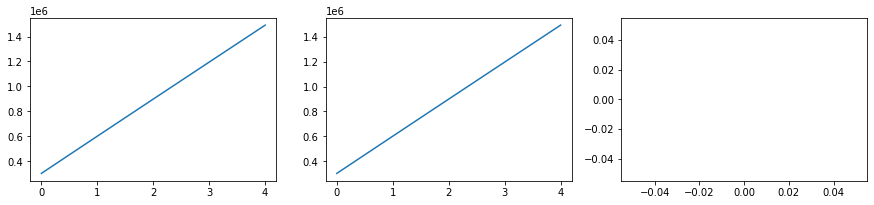

In [11]:

X = list(range(len(losses[0])))
fig, ax = plt.subplots(1,len(losses), figsize=(5*len(losses), 3))

for i in range(len(losses)):
    print(losses[i])
    plot(X, losses[i], ax=ax[i])

In [12]:
alpha = [0.5, 1.0, 2.5]
losses = []

for alpha in alpha:
    m, o, l = initialize_model(TARGET_RATE, len(labels), a=alpha, b=0.08, learning_rate=LEARNING_RATE)
    losses.append(train_model(m, o, l, train_set, labels, epochs=5, cap=10000))
    print(losses)


[[300923.53794550896, 599723.9561841488, 897378.3748984337, 1194443.2373621464, 1490969.0413513184]]
[[300923.53794550896, 599723.9561841488, 897378.3748984337, 1194443.2373621464, 1490969.0413513184], [300973.7843949795, 599993.4620547295, 897962.7015001774, 1195237.9910087585, 1491844.6964464188]]
[[300923.53794550896, 599723.9561841488, 897378.3748984337, 1194443.2373621464, 1490969.0413513184], [300973.7843949795, 599993.4620547295, 897962.7015001774, 1195237.9910087585, 1491844.6964464188], [301534.2657279968, 601118.8165290356, 899466.0213518143, 1196982.8970386982, 1493980.88611722]]


[300923.53794550896, 599723.9561841488, 897378.3748984337, 1194443.2373621464, 1490969.0413513184]
[300973.7843949795, 599993.4620547295, 897962.7015001774, 1195237.9910087585, 1491844.6964464188]
[301534.2657279968, 601118.8165290356, 899466.0213518143, 1196982.8970386982, 1493980.88611722]


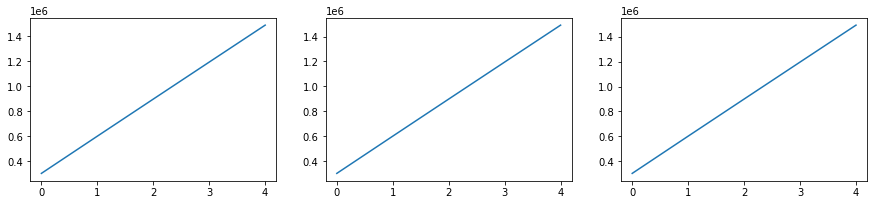

In [13]:

X = list(range(len(losses[0])))
fig, ax = plt.subplots(1,len(losses), figsize=(5*len(losses), 3))

for i in range(len(losses)):
    print(losses[i])
    plot(X, losses[i], ax=ax[i])